In [1]:
### SETUP ###
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import PIL
import PIL.Image
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow import keras


dirname = '/kaggle/input/celebrity-face-image-dataset/Celebrity Faces Dataset/'

class_count = 17
ds_size = 17*100 + 100

batch_size = 32
img_height = 180
img_width = 180

## Reference: https://www.tensorflow.org/tutorials/images/classification
## Use 80% of the images for training and 20% for validation.
## Below is 80% of Training
train_ds = tf.keras.utils.image_dataset_from_directory(
  dirname,
  validation_split=0.20,
  subset="training",
  seed=123,
  image_size=(img_height, img_width))

## Below is the 20% for Validation
test_ds = tf.keras.utils.image_dataset_from_directory(
  dirname,
  validation_split=0.20,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width))

## Creating test and validation datasets (10%-10%)
## Reference; https://stackoverflow.com/questions/48213766/split-a-dataset-created-by-tensorflow-dataset-api-in-to-train-and-test#:~:text=A%20robust%20way%20to%20split,by%20filtering%20by%20the%20bucket.
val_size = int(0.1 * ds_size)
test_size = int(0.1 * ds_size)

validation_ds = test_ds.take(val_size)
testing_ds = test_ds.skip(test_size)
print(f"testing_ds: {testing_ds}")
print(f"validation: {validation_ds}")

## Class Names
class_names = train_ds.class_names
print(test_ds.class_names)

## Do data augmentation to training and validation set only
## Reference: https://pyimagesearch.com/2021/06/28/data-augmentation-with-tf-data-and-tensorflow/



Found 1800 files belonging to 17 classes.
Using 1440 files for training.


2022-11-17 00:36:49.957908: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Found 1800 files belonging to 17 classes.
Using 360 files for validation.
testing_ds: <SkipDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>
validation: <TakeDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>
['Angelina Jolie', 'Brad Pitt', 'Denzel Washington', 'Hugh Jackman', 'Jennifer Lawrence', 'Johnny Depp', 'Kate Winslet', 'Leonardo DiCaprio', 'Megan Fox', 'Natalie Portman', 'Nicole Kidman', 'Robert Downey Jr', 'Sandra Bullock', 'Scarlett Johansson', 'Tom Cruise', 'Tom Hanks', 'Will Smith']


2022-11-17 00:36:50.250644: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


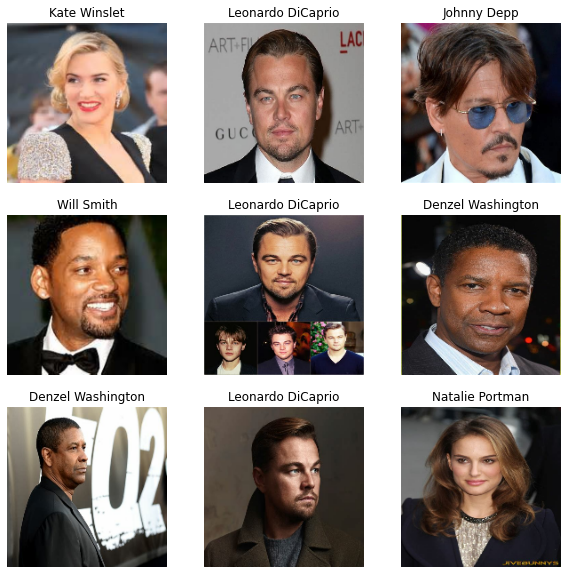

In [2]:
## Visualize the Data
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [3]:
# Batch size refers to the # of training examples utilized 
# in one iteration.
# I can call .numpy() on the image_batch and labels_batch tensors 
# to convert them to a numpy.ndarray.

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [4]:
# Standardize the Data
# The RGB channel values are in the [0, 255] range. 
# This is not ideal for a neural network.
# in general you should seek to make your input values small.
# Here, you will standardize values to be in the [0, 1] range 
# by using tf.keras.layers.
normalization_layer = layers.Rescaling(1./255)


In [5]:
# Create the Model
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [6]:
# Compile the Model
model.compile(optimizer='adam', 
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [7]:
# Model Summary
# View all layers of the network using Keras Model.summary method
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [8]:
# Train the Model
# Train the model for 10 epochs with the Keras Model.fit method
epochs = 10
history = model.fit(
    train_ds,
    validation_data = validation_ds,
    epochs = epochs
)

Epoch 1/10
45/45 [==============================] - 14s 296ms/step - loss: 2.8593 - accuracy: 0.1021 - val_loss: 2.8201 - val_accuracy: 0.1167
Epoch 2/10
45/45 [==============================] - 12s 263ms/step - loss: 2.6507 - accuracy: 0.1507 - val_loss: 2.5609 - val_accuracy: 0.1806
Epoch 3/10
45/45 [==============================] - 13s 276ms/step - loss: 2.1601 - accuracy: 0.3187 - val_loss: 2.4581 - val_accuracy: 0.2222
Epoch 4/10
45/45 [==============================] - 12s 263ms/step - loss: 1.5109 - accuracy: 0.5208 - val_loss: 2.6936 - val_accuracy: 0.2333
Epoch 5/10
45/45 [==============================] - 12s 274ms/step - loss: 0.8180 - accuracy: 0.7382 - val_loss: 3.1312 - val_accuracy: 0.2528
Epoch 6/10
45/45 [==============================] - 12s 266ms/step - loss: 0.3739 - accuracy: 0.8882 - val_loss: 4.0018 - val_accuracy: 0.2583
Epoch 7/10
45/45 [==============================] - 12s 266ms/step - loss: 0.1500 - accuracy: 0.9563 - val_loss: 4.6265 - val_accuracy: 0.2639

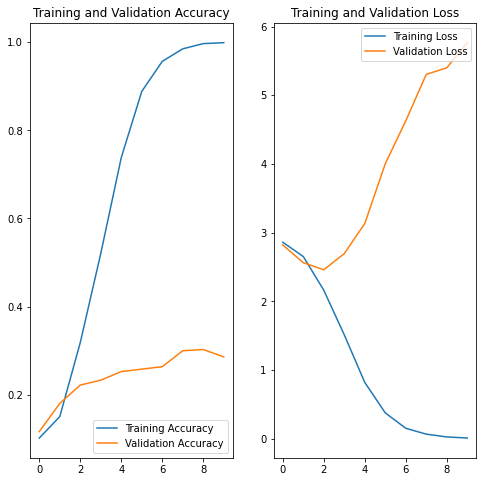

In [9]:
# Visualize Training Results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [10]:
# Data Augmentation
# Because our model is overfitting
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

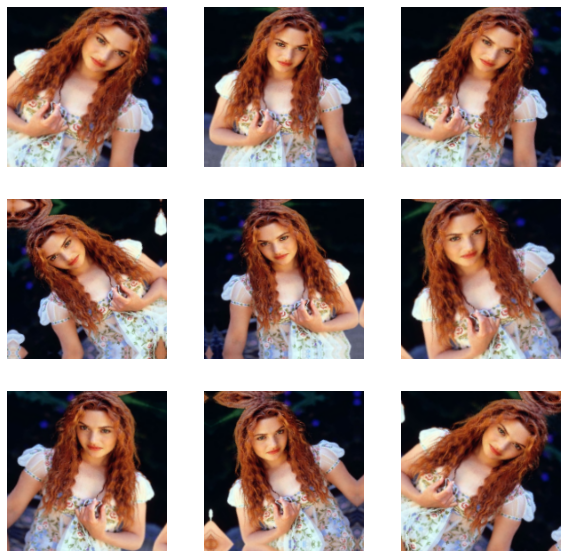

In [11]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [12]:
# Dropout
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [13]:
# Compile and Train the Model Again

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

epochs = 15
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs
)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

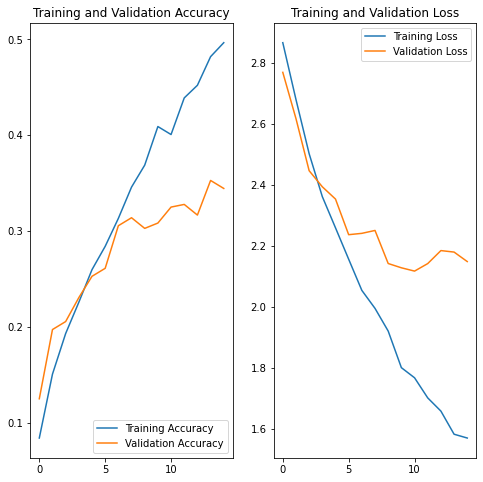

In [14]:
# Visualize Training Results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()